# Domaca naloga 1.2

Avtomatizirana izbira najbosega modela in nastavitev hiper parametrov.


In [1]:
import pandas as pd
import numpy as np

from hyperopt import hp, tpe, rand, fmin, Trials, space_eval
from hyperopt import pyll, base

import warnings

# ne izpisuje opozoril
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

data = pd.read_csv('podatki.csv')
X = data.drop('y', axis=1)
Y = data['y']
clas = Y.unique()
Y = Y.replace(clas[0], 0)
Y = Y.replace(clas[1], 1)

#print(Y)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc,columns=X.columns)
X_test_sc = scaler.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc,columns=X.columns)



Prvi poskus se je izkazal da zadeva predolgo melje zato sem se odlocil za mansanje dimenzij podatkov, vendar samo ob analiziranju potem sem vse pognal še z vsemi podatki. Izbral sem pristop **feature_importances_** tako da sem izbral prvih 7 najpomebnejsih znacilk, ker je pri tej znacilki AUC presegel vrednost 0.8.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate


np.random.seed(0)

rfo = RandomForestClassifier().fit(X_train, y_train)

col_name = X.columns
imprf = rfo.feature_importances_


sortind = np.argsort(-imprf)
sort_imprf = imprf[sortind]
sort_name = col_name[sortind]
#print(X_train[sort_name[0:0]])

for i in range(1, len(sort_name)):
    x_train = X_train[sort_name[0:i]]
    x_test = X_test[sort_name[0:i]]
    rf_imp = RandomForestClassifier()
    cv = cross_validate(rf_imp, x_train, y_train, cv=5,
                        scoring=('roc_auc'),
                        return_train_score=True)
    rf_imp.fit(x_train, y_train)
    pred = rf_imp.predict(x_test)
    print(f"cv = {np.mean(cv['test_score'])}")
    print(f"test = {roc_auc_score(pred, y_test)}")
    if roc_auc_score(pred, y_test) > 0.8:
        print(i)
        break
    
print(sort_name[0:i])


cv = 0.863463708557602
test = 0.7438640654499685
cv = 0.8569429683217973
test = 0.6790650406504065
cv = 0.890874744172675
test = 0.702527646129542
cv = 0.9126591789581873
test = 0.7174418604651163
cv = 0.9186002122358963
test = 0.7957535885167464
cv = 0.9173449704734751
test = 0.7499074074074075
cv = 0.9276619113121081
test = 0.8087182823682498
7
Index(['x1', 'x5', 'x3', 'x2', 'x4', 'x21', 'x27'], dtype='object')


In [3]:
max_depth = list(range(2, 50, 5))
min_samples_split = list(range(1, 20, 2))
min_samples_leaf = [1, 2, 3]
n_neighbors = list(range(2, 30, 2))
C = [1.0, 10.0]
kernel = ['linear', 'sigmoid', 'poly']
gnezdeni_prostor = {
    "algo": hp.choice('algo', [
        {
            'name': 'rf',
            'max_depth': hp.choice('max_depth', max_depth),
            'min_samples_split' : hp.choice('min_samples_split', min_samples_split),
            'min_samples_leaf' : hp.choice('min_samples_leaf', min_samples_leaf)

        },
        {
            'name': 'knn',
            'n_neighbors' : hp.choice('n_neighbors',n_neighbors)
        },
        {
            'name': 'svm',
            'C': hp.choice('C', C),
            'kernel': hp.choice('kernel', [
                {
                    'type': 'linear'  # linearno
                },
                {
                    'type': 'sigmoid'
                },
                {
                    'type': 'poly'
                }
            ]),
        },
    ])
}


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

np.random.seed(0)

# stevilo pomebnih znacilk, za namen hitrejsega ucenja
i = 7 
#Xi_train = X_train[sort_name[0:i]]
#Xi_test =  X_test[sort_name[0:i]]

Xi_train_sc = X_train_sc[sort_name[0:i]]
Xi_test_sc =  X_test_sc[sort_name[0:i]]

def kriteri_fn(params):
    a = params["algo"]
    algo_name = a["name"]
    if algo_name == "knn":
        model = KNeighborsClassifier(n_neighbors=a["n_neighbors"])

    elif algo_name == "rf":
        model = RandomForestClassifier(max_depth=a['max_depth'], 
                                       min_samples_split=a['min_samples_split'], 
                                       min_samples_leaf=a['min_samples_leaf'])

    elif algo_name == "svm":
        kernel = a["kernel"]["type"]
        C = a['C']
        model = SVC(kernel=kernel, C=C)
    else:
        raise ValueError("Wrong setings!")
    
    cv = cross_validate(model, X_train_sc, y_train, cv=5,
                        scoring=('roc_auc'),
                        return_train_score=True)

    return 1 - np.mean(cv['test_score'])


trials = Trials()
best = fmin(
            fn = kriteri_fn,
            space = gnezdeni_prostor,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials
            )
print(best)
best_m = space_eval(gnezdeni_prostor, best)
best_value = kriteri_fn(best_m)
print(best_m)



100%|██████████| 100/100 [00:32<00:00,  3.10trial/s, best loss: 0.0680893272056936]
{'algo': 0, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 0}
{'algo': {'max_depth': 27, 'min_samples_leaf': 2, 'min_samples_split': 1, 'name': 'rf'}}


In [5]:
print(f"Best algo with params {best_m}")
print(f"Best algo with params {1-best_value}")

Best algo with params {'algo': {'max_depth': 27, 'min_samples_leaf': 2, 'min_samples_split': 1, 'name': 'rf'}}
Best algo with params 0.930218319557546


In [6]:
from matplotlib import pyplot as plt

# potrebujem za pridobitev vrednosti paramatrev
params = {'max_depth':max_depth, 
          'min_samples_split':min_samples_split,
          'min_samples_leaf':min_samples_leaf,
          'n_neighbors':n_neighbors,
          'C':C,
          'kernel':kernel}

def get_evals(param):
    """ Iz trailsov potegne ven vrednosti paramatrov in njihov AUC """

    hyparam = [t['misc']['vals'][param] for t in trials.trials]
    vals = [1-t['result']['loss'] for t in trials.trials]
    calc_all = [element for innerList in hyparam for element in (innerList or [np.nan])]
    param_val = [params[param][element] for innerList in hyparam for element in innerList]
    
    auc = []
    for i in range(len(calc_all)):
        x = calc_all[i]
        if  str(x).isdigit():
            auc += [vals[i]]
    return auc, param_val


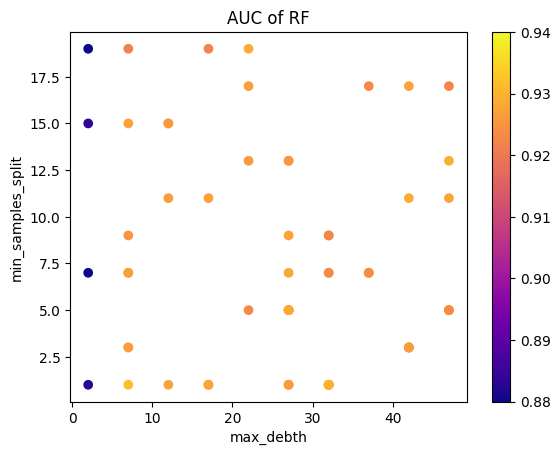

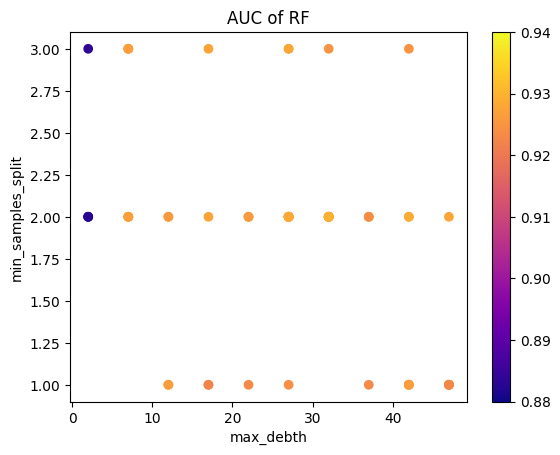

In [7]:
aucrf, max_dp = get_evals('max_depth')
_, min_ss = get_evals('min_samples_split')
_, min_sl = get_evals('min_samples_leaf')


sc=plt.scatter(max_dp, min_ss, c=aucrf, cmap='viridis')
plt.clim(0.88, 0.94)
plt.colorbar(sc)
plt.xlabel("max_debth")
plt.ylabel("min_samples_split")
sc.set_cmap('plasma')
plt.title('AUC of RF')
sc.set_clim(0.88, 0.94)
plt.savefig('porocilo/fig/rf1.png')
plt.show()

sc=plt.scatter(max_dp, min_sl, c=aucrf, cmap='viridis')
plt.clim(0.88, 0.94)
plt.colorbar(sc)
plt.xlabel("max_debth")
plt.ylabel("min_samples_split")
plt.title('AUC of RF')
sc.set_cmap('plasma')
sc.set_clim(0.88, 0.94)
plt.savefig('porocilo/fig/rf2.png')
plt.show()

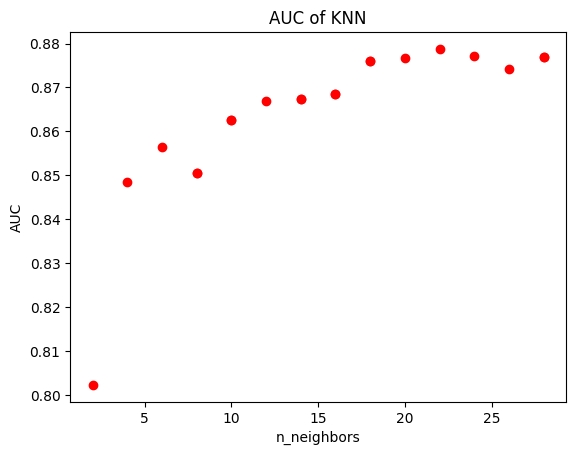

In [8]:
aucknn, k = get_evals('n_neighbors')

plt.scatter(k, aucknn ,c='r')
plt.xlabel("n_neighbors")
plt.ylabel("AUC")
plt.title('AUC of KNN')
plt.savefig('porocilo/fig/knn.png')
plt.show()



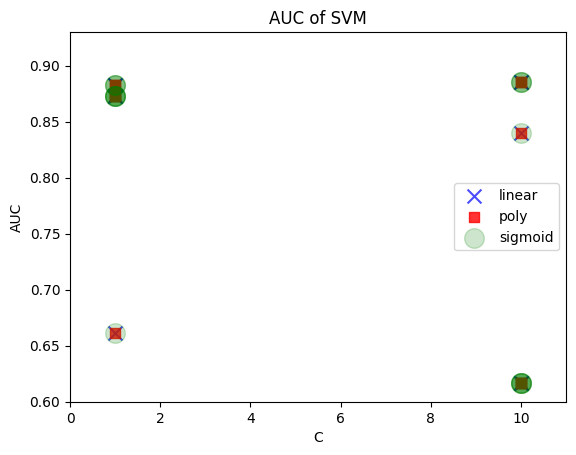

In [9]:
aucsvm, cc = get_evals('C')
_, jedra = get_evals('kernel')

lin = pol = sig = []
aucl = aucp = aucs = []  
for i,jedr in enumerate(jedra):
    if jedr == 'linear':
        lin.append(cc[i])
        aucl.append(aucsvm[i])
    elif jedr == 'poly':
        pol.append(cc[i])
        aucp.append(aucsvm[i])
    else:
        sig.append(cc[i])
        aucs.append(aucsvm[i])



fig, ax = plt.subplots()
ax.scatter(lin, aucl, label='linear',  marker='x', facecolor='blue', alpha=0.7, s=100)
ax.scatter(pol, aucp, label='poly',   marker='s', facecolor='red', alpha=0.8, s=50)
ax.scatter(sig, aucs, label='sigmoid', facecolor='green', alpha=0.2, s=200)
ax.set_xlabel('C')
ax.set_ylabel('AUC')
ax.set_title('AUC of SVM')
ax.legend()
plt.xlim(0, 11)
plt.ylim(0.6, 0.93)
plt.savefig('porocilo/fig/svm.png')


Sedaj pa se nataniram najboljsi model za pridobitev zmogljivosti s cv in na testnih primerih

In [18]:

np.random.seed(0)

bestmodel = RandomForestClassifier(max_depth=best_m['algo']['max_depth'], 
                                   min_samples_leaf=best_m['algo']['min_samples_leaf'], 
                                   min_samples_split=best_m['algo']['min_samples_split'])
cv = cross_validate(bestmodel, X_train_sc, y_train, cv=5,
                        scoring=('roc_auc'),
                        return_train_score=True)

bestmodel.fit(X_train_sc, y_train)
pred = bestmodel.predict(X_test_sc)
print(f'Best model params \n{best_m}')
print(f"AUC on cv = {np.mean(cv['test_score'])}")
print(f"AUC on test = {roc_auc_score(pred, y_test)}")



Best model params 
{'algo': {'max_depth': 27, 'min_samples_leaf': 2, 'min_samples_split': 1, 'name': 'rf'}}
AUC on cv = 0.9281014008709327
AUC on test = 0.8473346828609987
